## Test cases

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', 500)
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
plt.style.use('paper')

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]
from src.visualization.plot import track_plots, track_plot, plot, plot_parameters

2022-05-10 10:41:33,370 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-05-10 10:41:39,247 - root - INFO - ** Kedro project wPCC_pipeline
2022-05-10 10:41:39,248 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-05-10 10:41:39,257 - root - INFO - Registered line magic `run_viz`


In [2]:
model_test_ids.keys()

dict_keys(['wpcc', 'kvlcc2', 'LNG', 'tanker2', 'LNG_tanker', 'kvlcc2_cto', 'kvlcc2_hsva'])

In [249]:
ships = ['wpcc','LNG','kvlcc2_hsva']

ship_datas = {}
initial_parameters = {}

for ship in ships:
       
    ship_datas[ship] = catalog.load(f"{ship}.ship_data")
    initial_parameters[ship] = catalog.load(f"{ship}.initial_parameters")
    

ship_datas = pd.DataFrame(ship_datas)
ship_datas.dropna(how='any', inplace=True)

initial_parameters = pd.DataFrame(initial_parameters)
initial_parameters.drop(index='Xthrust', inplace=True)
mask = (initial_parameters!=0).all(axis=1)
initial_parameters = initial_parameters.loc[mask].copy()

2022-05-10 15:12:57,918 - kedro.io.data_catalog - INFO - Loading data from `wpcc.ship_data` (YAMLDataSet)...
2022-05-10 15:12:57,921 - kedro.io.data_catalog - INFO - Loading data from `wpcc.initial_parameters` (YAMLDataSet)...
2022-05-10 15:12:57,925 - kedro.io.data_catalog - INFO - Loading data from `LNG.ship_data` (YAMLDataSet)...
2022-05-10 15:12:57,928 - kedro.io.data_catalog - INFO - Loading data from `LNG.initial_parameters` (YAMLDataSet)...
2022-05-10 15:12:57,932 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.ship_data` (YAMLDataSet)...
2022-05-10 15:12:57,936 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial_parameters` (YAMLDataSet)...


In [246]:
ship_data_table = ship_datas.copy()
ship_data_table.rename(columns={'wpcc':'WPCC', 'kvlcc2_hsva': 'KVLCC2 (HSVA)'}, inplace=True)
ship_data_table = ship_data_table.transpose()
ship_data_table.drop(columns=['rho'], inplace=True)
ship_data_table.rename(
    columns={
        'T':'T [m]',
        'L':'L [m]',
        'B':'B [m]',
        'x_G': 'LCG [m]',
        'm': 'm [kg]',
        'I_z':'Izz [kg m2]',
        'volume':'Disp [m3]',
        'scale_factor':'scale factor',
        'TWIN':'Np',
    },
    
    inplace=True)

ship_data_table['Np']+=1
ship_data_table['Np']=ship_data_table['Np'].astype(int)

ship_data_table = ship_data_table.round(decimals=2)
glue("ship_datas", ship_data_table)

,T [m],L [m],CB,B [m],LCG [m],m [kg],Izz [kg m2],Disp [m3],scale factor,Np
WPCC,0.21,5.01,0.45,0.95,0.00,441.03,693.12,0.44,41.2,2
LNG,0.21,5.15,0.77,0.84,-0.05,715.46,1000.36,0.72,55.0,2
KVLCC2 (HSVA),0.46,7.00,0.81,1.27,0.24,3272.00,9908.58,3.27,45.7,1


In [254]:
initial_parameter_table = initial_parameters.rename(columns={'wpcc':'WPCC', 'kvlcc2_hsva': 'KVLCC2 (HSVA)'})
initial_parameter_table = initial_parameter_table.transpose()
initial_parameter_table = initial_parameter_table.round(decimals=6)

glue("initial_parameters", 1000*initial_parameter_table)

,Ndelta,Nr,Nrdot,Nv,Nvdot,Xudot,Ydelta,Yr,Yrdot,Yv,Yvdot
WPCC,-1.5,-1.719,-0.299,-3.184,-0.128,0.179,3.0,2.402,-0.303,-9.713,-6.109
LNG,-1.5,-1.675,-0.436,-3.205,-0.115,0.355,3.0,2.446,-0.309,-11.916,-7.246
KVLCC2 (HSVA),-1.5,-3.415,-0.822,-8.707,-1.166,1.050,3.0,4.305,-1.271,-25.266,-15.846


In [296]:
df_brix = pd.merge(left=initial_parameters, right=df_parameters, how='left', left_index=True, right_index=True)
df_brix.dropna(subset=['brix'], inplace=True)
brix = "brix_manoeuvring_1993"
df_brix['ref'] = brix

In [297]:
s_table = """
| Parameter                            |       Equation                    | Reference |
|:------------------------------------:|:---------------------------------:|:---------------------------------:|
"""
for name, parameter in df_brix.iterrows():
    
    glue(name, parameter['brix'])
    s_table+= f"| ${parameter['symbol']}$                            |       {{glue:}}`{name}`                     | {{cite:p}}`{parameter['ref']}` |\n"
    
print(s_table)

-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2

-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.0833333333333333)/L**2

-pi*T**2*(0.5 + 2.4*T/L)/L**2

-pi*T**2*(-0.04*B/T + 1.1*B/L)/L**2

2.0*m/(L**3*rho*(pi*sqrt(L**3/volume) - 14))

-pi*T**2*(-0.08*B/T + 2.2*B/L - 0.5)/L**2

-pi*T**2*(-0.0033*B**2/T**2 + 0.67*B/L)/L**2

-pi*T**2*(0.4*B*CB/T + 1)/L**2

-pi*T**2*(-5.1*B**2/L**2 + 0.16*B*CB/T + 1)/L**2


| Parameter                            |       Equation                    | Reference |
|:------------------------------------:|:---------------------------------:|:---------------------------------:|
| $N_{r}$                            |       {glue:}`Nr`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{\dot{r}}$                            |       {glue:}`Nrdot`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{v}$                            |       {glue:}`Nv`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{\dot{v}}$                            |       {glue:}`Nvdot`                     | {cite:p}`brix_manoeuvring_1993` |
| $X_{\dot{u}}$                            |       {glue:}`Xudot`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{r}$                            |       {glue:}`Yr`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{\dot{r}}$                            |       {glue:}`Yrdot`                     | {cit

Parameters in Abkowitz VMM:s are identified with the developed PIT for three test cases: WPCC, LNG and KVLCC2. Model test data from SSPA Maritime Dynamics Laboratory is used for WPCC, and LNG. Data from the SIMMAN2008 conference tested at HSVA is used for the KVLCC2. Main dimensions for the ship models used in these tests are summarized in [table](ship_datas).

```{glue:figure} ship_datas
:name: "ship_datas"

Ship data in model scale for WPCC, LNG tanker and KVLCC2.
```

### Initial guessed parameters
Following the PIT algorithm ([fig](overview)) first step is to make an initial guess for a linear VMM to be used in the the first EKF iteration.
The following semi-empirical formulas are used as initial guesses for hydrodynamic derivatives. 

| Parameter                            |       Equation                    | Reference |
|:------------------------------------:|:---------------------------------:|:---------------------------------:|
| $N_{r}$                            |       {glue:}`Nr`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{\dot{r}}$                            |       {glue:}`Nrdot`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{v}$                            |       {glue:}`Nv`                     | {cite:p}`brix_manoeuvring_1993` |
| $N_{\dot{v}}$                            |       {glue:}`Nvdot`                     | {cite:p}`brix_manoeuvring_1993` |
| $X_{\dot{u}}$                            |       {glue:}`Xudot`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{r}$                            |       {glue:}`Yr`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{\dot{r}}$                            |       {glue:}`Yrdot`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{v}$                            |       {glue:}`Yv`                     | {cite:p}`brix_manoeuvring_1993` |
| $Y_{\dot{v}}$                            |       {glue:}`Yvdot`                     | {cite:p}`brix_manoeuvring_1993` |

Calculated values for the three test cases can be seen in [fig](initial_parameters)

```{glue:figure} initial_parameters
:name: "initial_parameters"

Initial guess for linear hydrodynamic derivatives for WPCC, LNG tanker and KVLCC2. (Values have been multiplied by 1000)
```

### Motion regression
Hydrodynamic deriviatives in the Abkowitz model are identified with linear regression on forces and moments from the model tests inverse dynamics. A comparison between the inverse dynamic forces and prediction with the regressed mode is shown for one of the KVLCC2 model tests in [fig](force_prediction).

```{glue:figure} force_prediction
:name: "force_prediction"

Forces and moment from model test inverse dynamics and prediction with the regressed model.
```


In [567]:
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force

vmm_name = 'vmm_abkowitz'
id = 'HSVA_CPMC_KVLCC2_Z_20_10_S'
ship = 'kvlcc2_hsva'

data_ek_smooth = catalog.load(f"{ship}.initial.{id}.data_ek_smooth")
added_masses = catalog.load(f"{ship}.added_masses")
ship_parameters = catalog.load(f"{ship}.ship_data")
vmm = catalog.load(vmm_name)
regression = catalog.load(f"{ship}.initial.{vmm_name}.joined.regression")
df_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_parameters, vmm=vmm) 

2022-05-11 09:53:03,806 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial.HSVA_CPMC_KVLCC2_Z_20_10_S.data_ek_smooth` (CSVDataSet)...
2022-05-11 09:53:03,821 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.added_masses` (YAMLDataSet)...
2022-05-11 09:53:03,823 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.ship_data` (YAMLDataSet)...
2022-05-11 09:53:03,827 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz` (PickleDataSet)...
2022-05-11 09:53:03,940 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial.vmm_abkowitz.joined.regression` (PickleDataSet)...


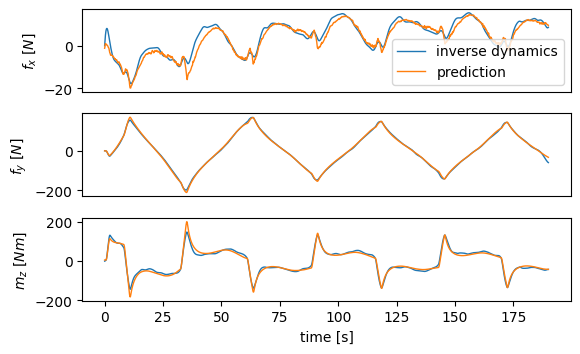

In [602]:
data_prime = regression.ps.prime(df_force, U = df_force['U'])

X, _ = regression.diff_eq_X.calculate_features_and_label(
            data=data_prime, y=data_prime['u']
        )

X = X[regression.X_X.columns].copy()

data_prime['fx'] = regression.model_X.predict(X) + data_prime['thrust']*regression.exclude_parameters['Xthrust']

X = regression.diff_eq_Y.calculate_features(data_prime)
data_prime['fy'] = regression.model_Y.predict(X)

X = regression.diff_eq_N.calculate_features(data_prime)
data_prime['mz'] = regression.model_N.predict(X)


data_prediction = regression.ps.unprime(data_prime, U=df_force['U'])

fig,axes=plt.subplots(nrows=3)

units = {'fx':'N',
         'fy':'N',
         'mz':'Nm'}
for ax,dof in zip(axes,['fx','fy','mz']):

    df_force.plot(y=dof, label='inverse dynamics', ax=ax)
    data_prediction.plot(y=dof, label='prediction', ax=ax)
    
    label=f"${dof[0]}_{dof[1]}$ $[{units[dof]}]$"
    
    ax.set_ylabel(label)
    ax.get_legend().set_visible(False)
    
axes[0].legend(loc='lower right')
axes[-1].set_xlabel('time [s]')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.tight_layout()

glue("force_prediction",fig, display=False)

### Iterations
The PIT algorithm is one more itteration. Simulation results with the initial guessed model and two iterrations of the PIT algorithm is shown in [fig](iterations). 
It can be seen that the first iteration of the PIT algorithm is much closer to the model test data compared to the initial guessed linear VMM model and the second iteration is even closer. The motion regression in the PIT algorithm has been run on all of the KVLCC2 model tests. 

```{glue:figure} iterations
:figwidth: 1000px
:name: "iterations"

Model test data for one of the KVLCC2 tests compared to simulations with initial model, PIT first iteration model and PIT second iteration model. 

```

In [603]:
#id = '22773'
#ship = 'wpcc'
id = 'HSVA_CPMC_KVLCC2_Z_20_10_S'
ship = 'kvlcc2_hsva'

data_raw = catalog.load(f"{ship}.{id}.data")
data_lowpass = catalog.load(f"{ship}.{id}.data_lowpass")

data = catalog.load(f"{ship}.initial.{id}.data_ek_smooth")
ek = catalog.load(f"{ship}.vmm_linear.ek")
model = catalog.load(f"{ship}.initial.vmm_linear.joined.model")


2022-05-11 10:24:38,297 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_20_10_S.data` (CSVDataSet)...
2022-05-11 10:24:38,318 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_20_10_S.data_lowpass` (CSVDataSet)...
2022-05-11 10:24:38,341 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial.HSVA_CPMC_KVLCC2_Z_20_10_S.data_ek_smooth` (CSVDataSet)...
2022-05-11 10:24:38,356 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.vmm_linear.ek` (ExtendedKalmanDataSet)...
2022-05-11 10:24:38,409 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial.vmm_linear.joined.model` (PickleDataSet)...


2022-05-11 10:24:39,418 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.initial.vmm_abkowitz.joined.HSVA_CPMC_KVLCC2_Z_20_10_S.data_resimulate` (CSVDataSet)...
2022-05-11 10:24:39,429 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.vmm_abkowitz.joined.HSVA_CPMC_KVLCC2_Z_20_10_S.data_resimulate` (CSVDataSet)...


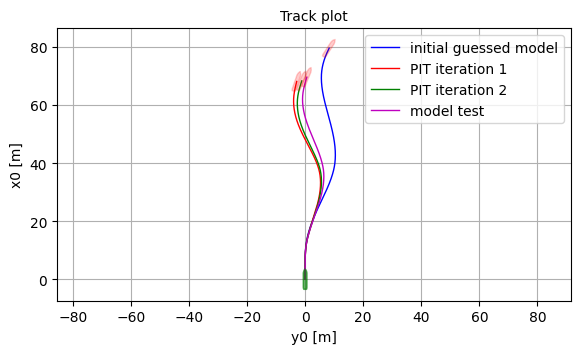

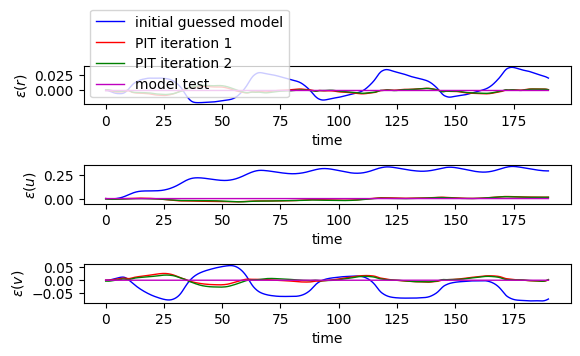

In [604]:
data['U'] = np.sqrt(data['u']**2 + data['v']**2)
df_sim = ek.simulate(data=data, input_columns=['delta','U'], solver='Radau')

dataframes = {
    'initial guessed model': df_sim,
    'PIT iteration 1': catalog.load(f"{ship}.initial.{vmm_name}.joined.{id}.data_resimulate"),
    'PIT iteration 2': catalog.load(f"{ship}.updated.{vmm_name}.joined.{id}.data_resimulate"),
    'model test' : data,
}

keys = ['u','v','r']
error_keys = [f'$\\epsilon({key})$' for key in keys]  
for key, df_ in dataframes.items():
    df_[error_keys]=df_[keys] - data[keys]

fig,ax=plt.subplots()
track_plots(dataframes, lpp=ship_datas[ship]['L'], beam=ship_datas[ship]['B'], time_window=[0,70], N=2, ax=ax);
glue("iterations",fig, display=False)

fig = plot(dataframes, keys=error_keys, ncols=1);
plt.tight_layout()
glue("iteration_errors",fig, display=False)

rmse = {}
rmse_keys = [f'$RMSe({key})$' for key in keys] 
for key, df_ in dataframes.items():
    rmse[key] = np.sqrt((df_[error_keys]**2).mean())
    

rmse = pd.DataFrame(rmse)

r = rmse.loc['$\\epsilon(r)$']
u = rmse.loc['$\\epsilon(u)$']
v = rmse.loc['$\\epsilon(v)$']
rmse.loc['total'] = u+v+r*ship_datas[ship]['L']/2

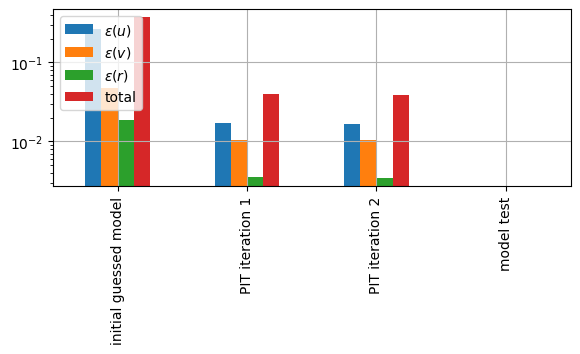

In [461]:
fig,ax=plt.subplots()
rmse.transpose().plot.bar(ax=ax);
ax.set_yscale('log')
ax.grid()
ax.legend(loc='upper left');
glue("iteration_error_bars",fig, display=False)

In [5]:
%reload_kedro

def load_model_tests_ship(ship = 'wpcc'):
    
    model_tests = model_test_ids[ship]
    
    dfs = []
    
    for id in model_tests:
        
        df_ = catalog.load(f"{ship}.{id}.data")

            
        df_['id'] = id
        dfs.append(df_)
            
    df = pd.concat(dfs)
    
    return df


2022-05-10 10:41:40,692 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-05-10 10:41:46,863 - root - INFO - ** Kedro project wPCC_pipeline
2022-05-10 10:41:46,863 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-05-10 10:41:46,872 - root - INFO - Registered line magic `run_viz`


In [6]:
def select_model_tests(df, n=9):
    df['|psi|'] = df['psi'].abs()
    
    indexes = df.groupby(by='id')['|psi|'].max().sort_values(ascending=False).index[0:n]
    mask = df['id'].isin(indexes)
    df_select = df[mask]
    return df_select

In [7]:
def plot_ship(df_select, ship, vmm="vmm_abkowitz"):
    
    fig,axes = plt.subplots(ncols=3, nrows=3)
    fig.set_size_inches(14,10)
    axes = axes.flatten()
    for ax, (id, df_) in zip(axes,df_select.groupby(by='id')):
        
        prediction = catalog.load(f"{ship}.updated.{vmm}.joined.{id}.data_resimulate")

        mask = df_['x0'] < 60
        df_ = df_.loc[mask]
        mask = prediction['x0'] < 60
        prediction = prediction.loc[mask]
        
        
        dataframes = {
            'model test':df_,
            'prediction':prediction,
            
        }
        
        track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'], ax=ax, N=4)
        ax.get_legend().set_visible(False)
        ax.set_title(None)
    
    axes[0].legend()
    fig.suptitle(f'Track plots: {ship}')
    plt.tight_layout()
    return fig
    

2022-05-10 10:41:47,281 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22611.data` (CSVDataSet)...
2022-05-10 10:41:47,317 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22612.data` (CSVDataSet)...
2022-05-10 10:41:47,369 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22613.data` (CSVDataSet)...
2022-05-10 10:41:47,424 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22614.data` (CSVDataSet)...
2022-05-10 10:41:47,478 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22615.data` (CSVDataSet)...
2022-05-10 10:41:47,536 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22616.data` (CSVDataSet)...
2022-05-10 10:41:47,585 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22635.data` (CSVDataSet)...
2022-05-10 10:41:47,651 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22639.data` (CSVDataSet)...
2022-05-10 10:41:47,723 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22764.data` (CSVDataSet)...
2022-05-10 10:41:47

2022-05-10 10:41:50,511 - kedro.io.data_catalog - INFO - Loading data from `LNG.17876.data` (CSVDataSet)...
2022-05-10 10:41:50,543 - kedro.io.data_catalog - INFO - Loading data from `LNG.17877.data` (CSVDataSet)...
2022-05-10 10:41:50,568 - kedro.io.data_catalog - INFO - Loading data from `LNG.17878.data` (CSVDataSet)...
2022-05-10 10:41:50,589 - kedro.io.data_catalog - INFO - Loading data from `LNG.17879.data` (CSVDataSet)...
2022-05-10 10:41:50,611 - kedro.io.data_catalog - INFO - Loading data from `LNG.17881.data` (CSVDataSet)...
2022-05-10 10:41:50,630 - kedro.io.data_catalog - INFO - Loading data from `LNG.17882.data` (CSVDataSet)...
2022-05-10 10:41:50,647 - kedro.io.data_catalog - INFO - Loading data from `LNG.17883.data` (CSVDataSet)...
2022-05-10 10:41:50,664 - kedro.io.data_catalog - INFO - Loading data from `LNG.17884.data` (CSVDataSet)...
2022-05-10 10:41:50,678 - kedro.io.data_catalog - INFO - Loading data from `LNG.17885.data` (CSVDataSet)...
2022-05-10 10:41:50,703 - ke

2022-05-10 10:41:53,403 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_05_01.data` (CSVDataSet)...
2022-05-10 10:41:53,417 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_10_01.data` (CSVDataSet)...
2022-05-10 10:41:53,431 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_10_05.data` (CSVDataSet)...
2022-05-10 10:41:53,445 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_10_10_P.data` (CSVDataSet)...
2022-05-10 10:41:53,454 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_10_10_S.data` (CSVDataSet)...
2022-05-10 10:41:53,462 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_15_01.data` (CSVDataSet)...
2022-05-10 10:41:53,476 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.HSVA_CPMC_KVLCC2_Z_15_05.data` (CSVDataSet)...
2022-05-10 10:41:53,491 - kedro.io.data_catalog - I

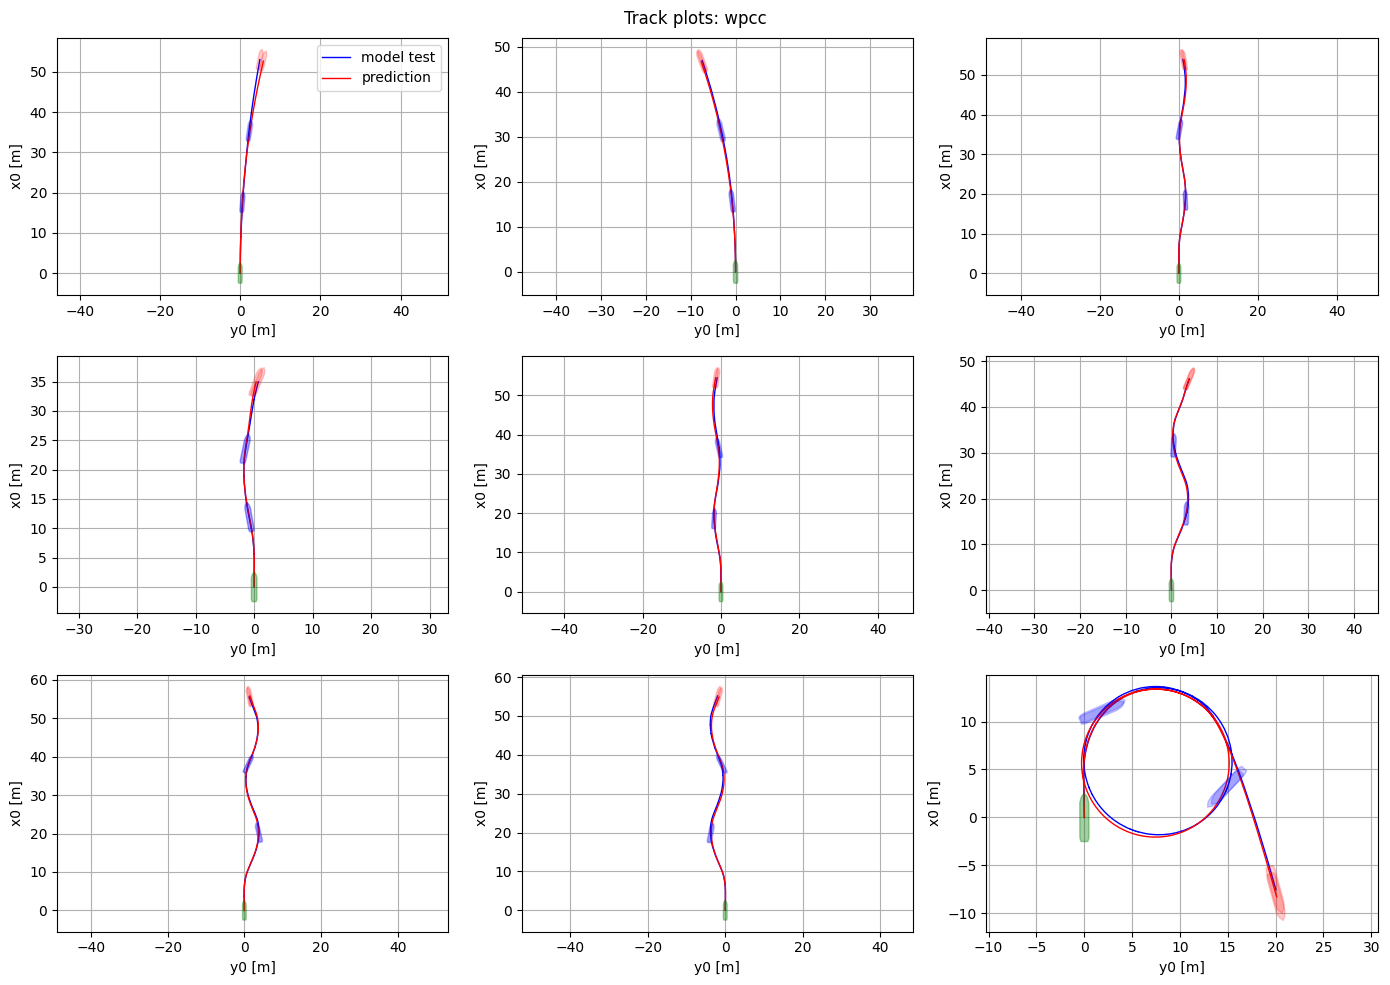

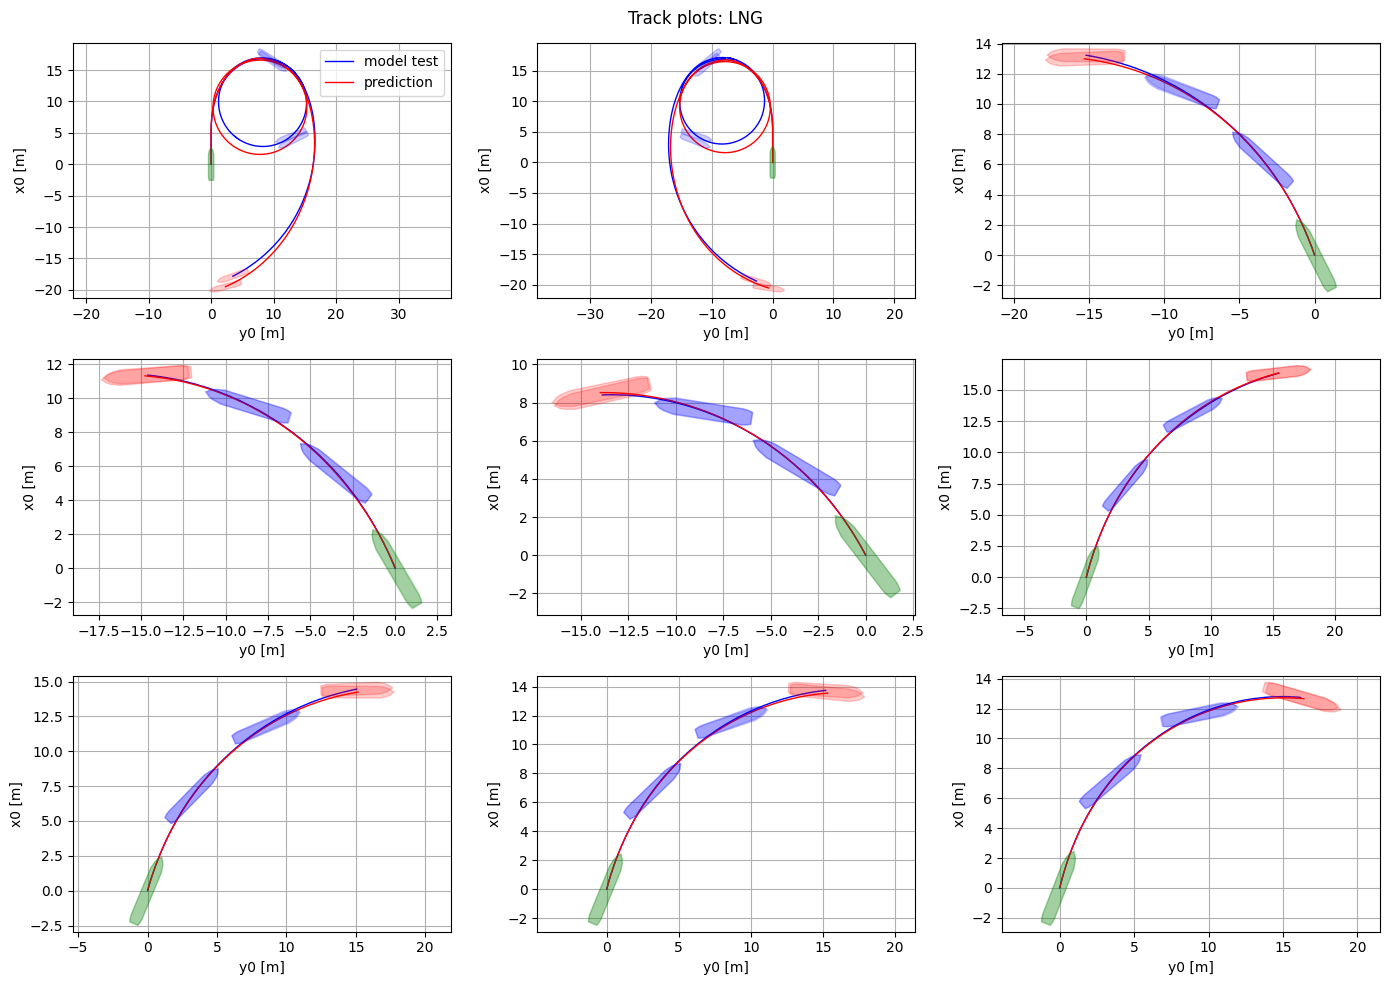

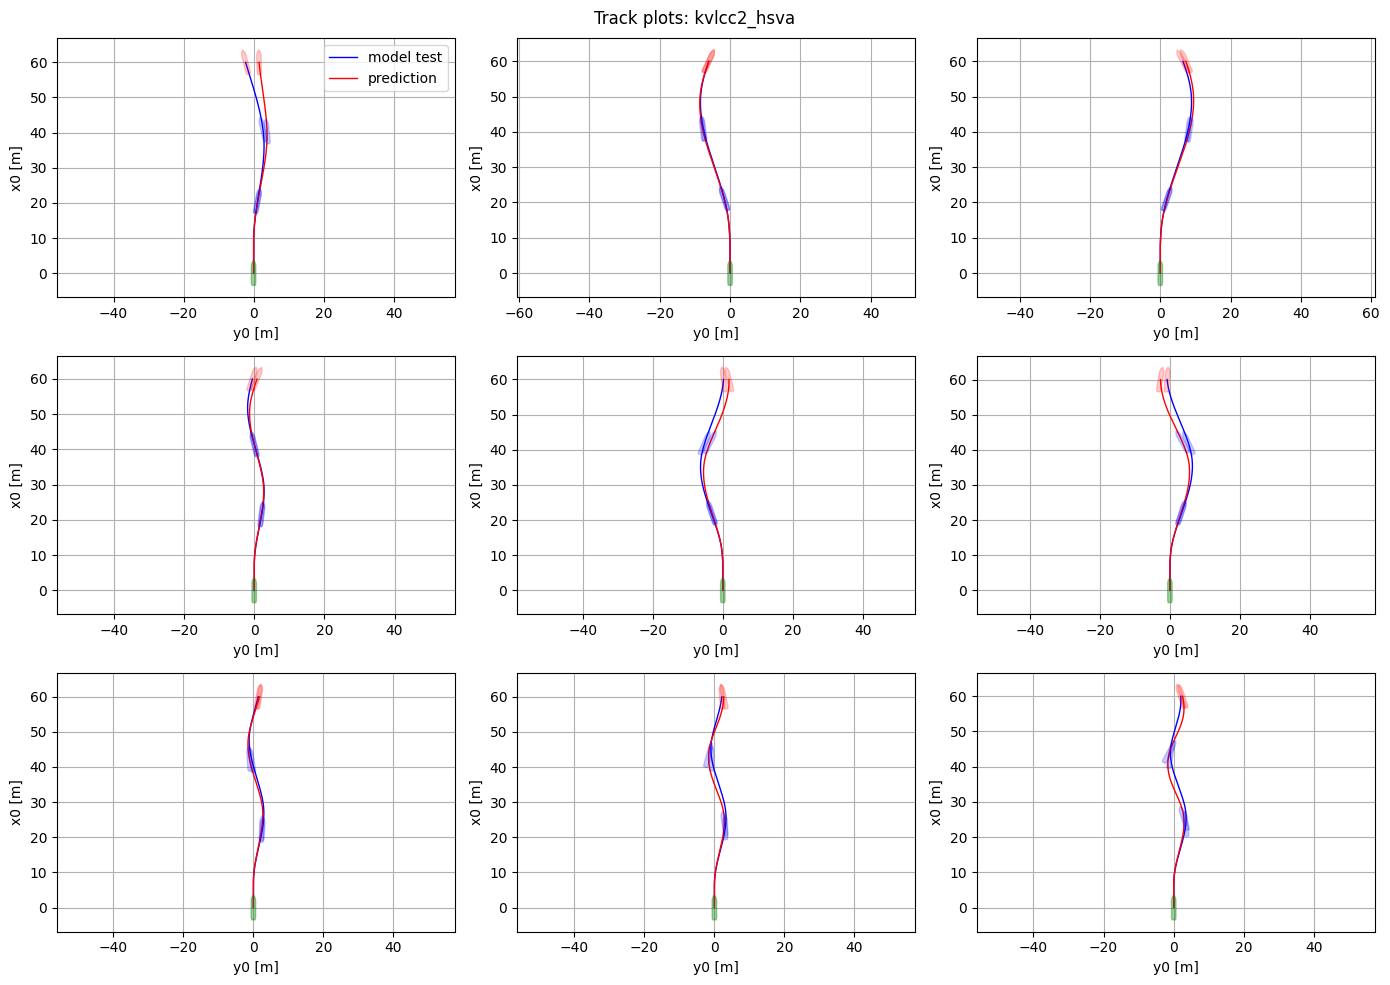

In [8]:
for ship in ships:
    
    df = load_model_tests_ship(ship=ship)
    ship_data = catalog.load(f"{ship}.ship_data")
    df_select = select_model_tests(df=df)
    fig = plot_ship(df_select, ship, vmm='vmm_abkowitz')
    glue(ship, fig, display=False)

### Simulations

Comparisons of model test and corresponding simulations with identified Abkowitz model can be seen for three test cases in [fig](wpcc), [fig](LNG) and [fig](kvlcc2_hsva).

```{glue:figure} wpcc
:figwidth: 1000px
:name: "wpcc"

Comparison of model tests and simulations with identified Abkowitz model for WPCC.
```

```{glue:figure} LNG
:figwidth: 1000px
:name: "LNG"

Comparison of model tests and simulations with identified Abkowitz model for LNG.
```

```{glue:figure} kvlcc2_hsva
:figwidth: 1000px
:name: "kvlcc2_hsva"

Comparison of model tests and simulations with identified Abkowitz model for KVLCC2.
```



### Multicollinearity

2022-05-10 13:18:14,939 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.vmm_abkowitz.joined.regression` (PickleDataSet)...


e:\dev\wpcc\src\visualization\plot.py:428: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


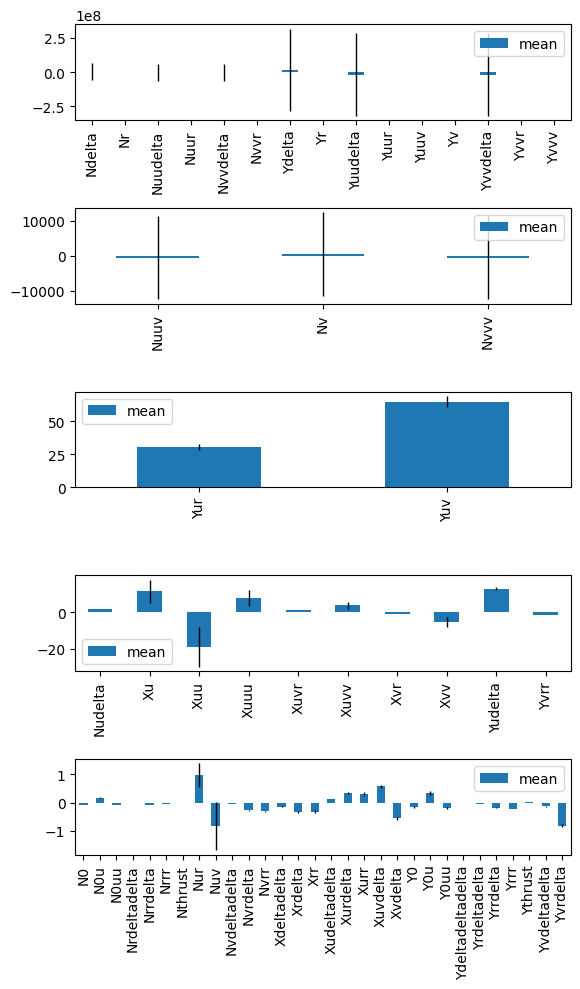

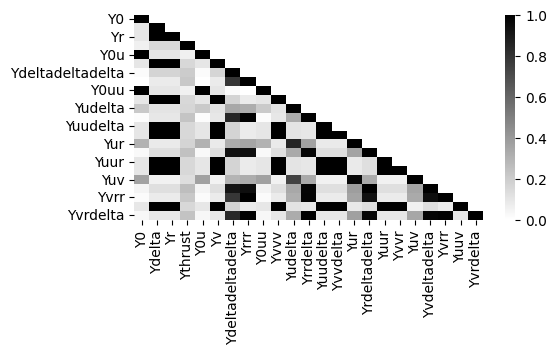

In [88]:
regression_abkowitz = catalog.load("kvlcc2_hsva.updated.vmm_abkowitz.joined.regression")
parameters = pd.DataFrame()
parameters['mean'] = regression_abkowitz.parameters['regressed']

std = dict(regression_abkowitz.model_X.bse)
std.update(regression_abkowitz.model_Y.bse)
std.update(regression_abkowitz.model_N.bse)
std = pd.Series(std)

parameters['std'] = std
quantile_cuts = [0.5, 0.67, 0.70, 0.75]
fig = plot_parameters(parameters, quantile_cuts=quantile_cuts);
fig.set_size_inches(5.9055,10)
plt.tight_layout()
glue("parameters_abkowits", fig, display=False)

import seaborn as sns

model = regression_abkowitz.model_Y

cov = model.cov_HC0

diag = np.sqrt(np.diag(np.diag(cov)))
gaid = np.linalg.inv(diag)
corr = gaid @ cov @ gaid
corr = np.tril(corr)
corr = pd.DataFrame(corr, index=model.params.keys(), columns=model.params.keys())

fig,ax=plt.subplots()
grid = sns.heatmap(corr.abs(), cmap='gray_r')
glue("heatmap_parameters", grid.figure, display=False)

2022-05-10 13:37:17,135 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.vmm_martins_simple.joined.regression` (PickleDataSet)...


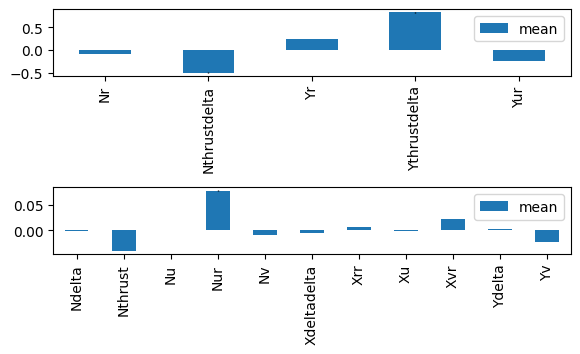

In [122]:
regression_simple = catalog.load("kvlcc2_hsva.updated.vmm_martins_simple.joined.regression")
parameters = pd.DataFrame()
parameters['mean'] = regression_simple.parameters['regressed']

std = dict(regression_simple.model_X.bse)
std.update(regression_simple.model_Y.bse)
std.update(regression_simple.model_N.bse)
std = pd.Series(std)

parameters['std'] = std
quantile_cuts = [0.7]
fig = plot_parameters(parameters, quantile_cuts=quantile_cuts);
glue("parameters_martins_simple", fig, display=False)

In [610]:
glue('regression_abkowitz_summary', regression_abkowitz.model_Y.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fy   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 5.056e+05
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        14:31:47   Log-Likelihood:             2.9229e+05
No. Observations:               42400   AIC:                        -5.845e+05
Df Residuals:                   42380   BIC:                        -5.844e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Y0                  -0.1670      0.036     -4.624      0.000      -0.238      -0.096
Ydelta            1.813e+07   2.99e+08      0.061      0.952   -5.69e+08    6.05e+08
Yr                -2.77e+04   4.57e+05     -0.061      0.952   -9.24e+05    8.69e+05
Ythrust              0.0174      0.002     10.060      0.000       0.014       0.021
Y0u                  0.3426      0.073      4.704      0.000       0.200       0.485
Yv                3580.7395   5.97e+04      0.060      0.952   -1.13e+05    1.21e+05
Ydeltadeltadelta    -0.0062      0.000    -13.951      0.000      -0.007      -0.005
Yrrr                -0.2298      0.013    -17.944      0.000      -0.255      -0.205
Y0uu                -0.1757      0.037     -4.783      0.000      -0.248      -0.104
Yvvv             -3615.8223   5.97e+04     -0.061      0.952   -1.21e+05    1.13e+05
Yudelta             12.6852      0.690     18.381      0.000      11.333      14.038
Yrrdelta            -0.1770      0.013    -14.155      0.000      -0.201      -0.152
Yuudelta         -1.813e+07   2.99e+08     -0.061      0.952   -6.05e+08    5.69e+08
Yvvdelta         -1.813e+07   2.99e+08     -0.061      0.952   -6.05e+08    5.69e+08
Yur                 30.5808      2.058     14.859      0.000      26.547      34.615
Yrdeltadelta        -0.0574      0.004    -14.249      0.000      -0.065      -0.050
Yuur              2.767e+04   4.57e+05      0.060      0.952   -8.69e+05    9.24e+05
Yvvr              2.768e+04   4.57e+05      0.061      0.952   -8.69e+05    9.24e+05
Yuv                 64.9347      4.278     15.178      0.000      56.549      73.320
Yvdeltadelta        -0.1292      0.008    -15.566      0.000      -0.145      -0.113
Yvrr                -1.6102      0.078    -20.557      0.000      -1.764      -1.457
Yuuv             -3645.6991   5.97e+04     -0.061      0.951   -1.21e+05    1.13e+05
Yvrdelta            -0.8153      0.051    -15.906      0.000      -0.916      -0.715
==============================================================================
Omnibus:                    15458.144   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1131470.490
Skew:                          -0.887   Prob(JB):                         0.00
Kurtosis:                      28.245   Cond. No.                     7.21e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.42e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [612]:
glue('regression_simple_summary', regression_simple.model_Y.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          9.988e+05
Date:                Wed, 11 May 2022   Prob (F-statistic):                        0.00
Time:                        14:33:07   Log-Likelihood:                      2.8233e+05
No. Observations:               42400   AIC:                                 -5.647e+05
Df Residuals:                   42394   BIC:                                 -5.646e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Ydelta           0.0031   1.64e-05    187.041      0.000       0.003       0.003
Yr               0.2386      0.001    229.160      0.000       0.237       0.241
Yu            4.509e-05   1.52e-06     29.756      0.000    4.21e-05    4.81e-05
Yv              -0.0229   9.01e-05   -254.035      0.000      -0.023      -0.023
Ythrustdelta     0.8346      0.005    152.185      0.000       0.824       0.845
Yur             -0.2346      0.001   -223.846      0.000      -0.237      -0.233
==============================================================================
Omnibus:                    10574.552   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           674935.457
Skew:                          -0.232   Prob(JB):                         0.00
Kurtosis:                      22.540   Cond. No.                     3.62e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The printout from the OLS Regression results for Abkowitz fy-equation for KVLCC2 data is shown in [fig](regression_abkowitz_summary). The printout shows the regressed parameters (coef) together with, standard deviation (std err) and confidence intervals ([0.025 	0.975]). The P-values from hypothesis tests (P>|t|) is very high for some of the parameters such as: $Y_{\delta}$, $Y_r$ etc. This is indicating that the model has too many parameters for the present dataset. Strong multicollinearity is also reported which is a known problem for the the VMM:s {cite:p}`luo_parameter_2016`, {cite:p}`wang_quantifying_2018`. The coefficients which are found do not
have to be physically correct, but mathematically correct {cite:p}`ittc_maneuvering_2008` which is also something that is shown here, where some of the parameters have very large values (in the order of 10^8). This means that the regressed Abkowitz model for KVLCC2 does a very good job in describing the known data, that we see here, but will not work very well when extrapolating outside the known data, when making predictions.

```{glue:figure} regression_abkowitz_summary
:figwidth: 1000px
:name: "regression_abkowitz_summary"

Regression result for Abkowitz model fy equation on KVLCC2 data. 
```

Printout from an OLS Regression for a simplified Abkowitz fy-equation for KVLCC2 data is shown in [fig](regression_simple_summary). This model has almost as high accuracy as the full Abkowitz model when comparing the R^2 values (0.996 compared to 0.993). The coefficients in this model also have much smaller values and smaller P-values. So this means that the simplified model describes the known data almost as good as the full Abkowitz model, but will most likely work better when making predictions outside the known data.

```{glue:figure} regression_simple_summary
:figwidth: 1000px
:name: "regression_simple_summary"

Regression result for simplified Abkowitz model fy equation on KVLCC2 data. 
```

The identified parameters of an Abkowitz model for KVLCC2 are shown in [figure](parameters_abkowits). 
It can be seen that the uncertainty (standard deviation of the estimated parameters), indicated by the black error bars, is very high for some of the parameters.
It can also be seen that some of the parameters have very high values, in the order of 10^8. 

Identifying parameters of a simplified Abkowitz model for KVLCC2 gives much smaller parameters and lower uncertainty as seen in [figure](parameters_martins_simple).

```{glue:figure} parameters_abkowits
:figwidth: 1000px
:name: "parameters_abkowits"

Identified parameters in Abkowitz model for KVLCC2.
```

```{glue:figure} parameters_martins_simple
:figwidth: 1000px
:name: "parameters_martins_simple"

Identified parameters in simplified Abkowitz model for KVLCC2.
```

Can the regressed Abkowitz model be trusted considering the high uncertainty in the parameter values? 

This can be investigated using Monte Carlo simulations with alternative realizations of the regression. 
Manoeuvre simulation can be performed with parameter sets taken as random samples from a multivariate gausian distribution defined by the mean values and 
covariance matrix from the linear regression.

The covariance matrix needs to be included in the Monte Carlo simulations since there is high correlation between some of the parameters as seen in [fig](heatmap_parameters).

```{glue:figure} heatmap_parameters
:figwidth: 1000px
:name: "heatmap_parameters"

Absolute correlation coefficient of identified parameters in Abkowitz model for KVLCC2.
```

In [100]:
from scipy.linalg import block_diag
from scipy.stats import norm, multivariate_normal
import tqdm
import sys
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler

In [213]:
regression = regression_abkowitz
means = pd.concat([regression.model_X.params,regression.model_Y.params,regression.model_N.params])
covs = [regression.model_X.cov_HC0,regression.model_Y.cov_HC0,regression.model_N.cov_HC0]

std = regression.model_X.bse.copy()
std=std.append(regression.model_Y.bse)
std=std.append(regression.model_N.bse)

cov = block_diag(*covs)

rv = multivariate_normal(mean=means.values, cov=cov, allow_singular=True)
np.random.seed(42)
N_=10
df_parameter_variation = pd.DataFrame(data=rv.rvs(N_), columns=means.index)

E:\dev\wPCC_pipeline\venv\lib\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [214]:
#for key in means.keys():
#
#    rv = norm(loc=means[key], scale=std[key])
#    
#    xs = np.linspace(df_parameter_variation[key].min(), df_parameter_variation[key].max(),100)
#    
#    grid = sns.displot(data=df_parameter_variation[key], kind='hist', stat="density")
#    
#    ax = grid.ax
#    ax.plot(xs, rv.pdf(xs));



In [215]:
def monte_carlo(data_smooth, df_parameter_variation, model, ek):

    dataframes = {}
    with tqdm.tqdm(total=len(df_parameter_variation), file=sys.stdout) as pbar:
        for index, parameters_ in df_parameter_variation.iterrows():
            model_ = model.copy()
            model_.parameters.update(parameters_)
            
            df_ = simulate_euler(data=data_smooth, model=model_,ek=ek, solver='Radau') 
            dataframes[index] = df_
        
            pbar.update(1)
        
    return dataframes

In [216]:
#vmm_name = 'vmm_abkowitz_simple'
#vmm_name = 'vmm_martins_simple'
vmm_name = 'vmm_abkowitz'
#id = 'HSVA_CPMC_KVLCC2_Z_15_05'
id = 'HSVA_CPMC_KVLCC2_Z_25_05'

model = catalog.load(f"kvlcc2_hsva.updated.{ vmm_name }.joined.model")
ek = catalog.load(f"kvlcc2_hsva.{ vmm_name }.ek")

#id = 22774
#regression = catalog.load(f"{ vmm_name }.motion_regression.no_circle.regression")
df_smooth = catalog.load(f"kvlcc2_hsva.updated.{ id }.data_ek_smooth")
ship = "kvlcc2_hsva"
df_sim = catalog.load(f"{ ship }.updated.{ vmm_name }.joined.{ id }.data_resimulate")



2022-05-10 14:25:04,184 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.vmm_abkowitz.joined.model` (PickleDataSet)...
2022-05-10 14:25:04,191 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.vmm_abkowitz.ek` (ExtendedKalmanDataSet)...
2022-05-10 14:25:04,198 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.HSVA_CPMC_KVLCC2_Z_25_05.data_ek_smooth` (CSVDataSet)...
2022-05-10 14:25:04,212 - kedro.io.data_catalog - INFO - Loading data from `kvlcc2_hsva.updated.vmm_abkowitz.joined.HSVA_CPMC_KVLCC2_Z_25_05.data_resimulate` (CSVDataSet)...


In [224]:
model.turning_circle(

In [217]:
dataframes = monte_carlo(df_smooth, df_parameter_variation, model=model, ek=ek)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.08s/it]


In [218]:
dataframes['model test'] = df_smooth
dataframes['VMM all'] = df_sim

In [219]:
styles={'model test':{'style':'k-','lw':2},
       'VMM all':{'style':'r-','lw':2},
        
       }

for index, parameters_ in df_parameter_variation.iterrows():
    styles[index] = {'style':'b-', 
                     'alpha':0.1,
                     'label':'_Hidden label'}

#for dataframes_ in displays:
#    fig,ax=plt.subplots()
#    grid.fig.set_size_inches(0.7*np.array(matplotlib.rcParams["figure.figsize"]))
#    
#    ax = track_plots(dataframes_, lpp=ship_data['L'], beam=ship_data['B'], plot_boats=False, flip=True, N=7, styles=styles, ax=ax)
#    #ax.set_xlim(0,25)
#    #ax.set_ylim(-20,5)   

E:\dev\wPCC_pipeline\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EFBA6D0688> has a label of '_Hidden label' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
E:\dev\wPCC_pipeline\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EFBA4070C8> has a label of '_Hidden label' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
E:\dev\wPCC_pipeline\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EFAA3FD308> has a label of '_Hidden label' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
E:\dev\wPCC_pipeline\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: Th

<AxesSubplot:title={'center':'Track plot'}, xlabel='x0 [m]', ylabel='y0 [m]'>

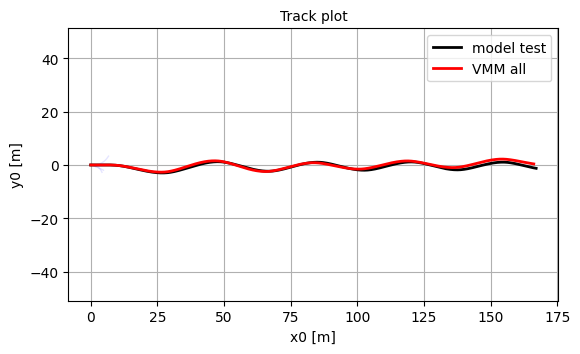

In [220]:
fig,ax=plt.subplots()
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'], plot_boats=False, flip=True, N=7, styles=styles, ax=ax)
   